In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
root_path = Path("/home/onkar/Good/images/datasets/P1_Facial_Keypoints/")

full_df = pd.read_csv(root_path/"training_frames_keypoints.csv")

print(len(full_df))

3462


In [3]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from copy import deepcopy
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FacesData(Dataset):
    def __init__(self, csv_fl, data_loc):
        df = pd.read_csv(csv_fl)
        self.df = df.reset_index(drop=True)
        self.data_loc = data_loc
        
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # ----- 1. Build image path -----
        img_name = self.df.iloc[index, 0]
        img_path = f"{self.data_loc}/{img_name}"
        
        # ----- 2. Read and scale image to [0,1] -----
        img_bgr = cv2.imread(str(img_path)) # HWC -> BGR
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img = img / 255.0 # HWC -> RGB
        
        # ----- 3. Get keypoints and normalize by image size -----
        # all keypoint values (columns 1: )
        kp = deepcopy(self.df.iloc[index, 1:].tolist())
        
        # even indices -> x, odd indices -> y
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist() # divide by width
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist() # divide by height
        
        # concatenate back and convert to tensor
        kp2 = torch.tensor(kp_x + kp_y, dtype=torch.float32)
        
        # ----- 4. Preprocess image for VGG16 -----
        img = self.preprocess_input(img)
    
        # return image and normalized keypoints
        return img, kp2
        
    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img
    
    def load_image(self, index):
        img_name = self.df.iloc[index, 0]
        img_path = f"{self.data_loc}/{img_name}"
        print(f"Image path: {img_path}")
        
        img_bgr = cv2.imread(str(img_path)) # HWC, BGR
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)/255.0
        img = cv2.resize(img, (224, 224))
        
        return img

Training data size: 2970
Validation data size: 492
Test data size: 770
TRAIN: images.shape: torch.Size([3, 224, 224]), kpoints.shape: torch.Size([136])
VALID: images.shape: torch.Size([3, 224, 224]), kpoints.shape: torch.Size([136])
TEST : images.shape: torch.Size([3, 224, 224]), kpoints.shape: torch.Size([136])
Image path: /home/onkar/Good/images/datasets/P1_Facial_Keypoints//test/James_Wolfensohn_00.jpg


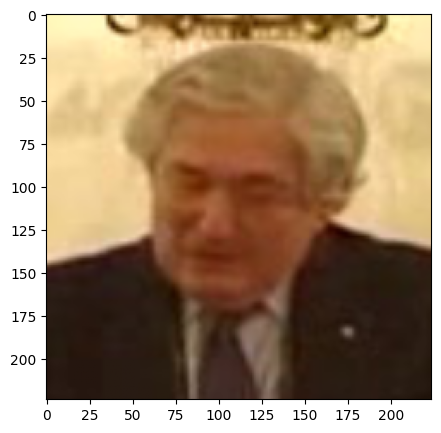

In [4]:
from sklearn.model_selection import train_test_split

dataset_root_path = "/home/onkar/Good/images/datasets/P1_Facial_Keypoints/"
train_csv_fl = "training_frames_keypoints.csv"

full_train_df = pd.read_csv(f"{dataset_root_path}/{train_csv_fl}")

# split the training data into train and valid set
mask_train_df = np.random.rand(len(full_train_df)) < 0.85
train_df = full_train_df[mask_train_df]
valid_df = full_train_df[~mask_train_df]

train_df.to_csv(f"{dataset_root_path}/train_data.csv", index=False)
valid_df.to_csv(f"{dataset_root_path}/valid_data.csv", index=False)

# -----------------  training dataset -----------------------------
train_csv_fl = f"{dataset_root_path}/train_data.csv"
train_data_loc = f"{dataset_root_path}/train"

train_ds = FacesData(train_csv_fl, train_data_loc)

# ------------------ Validation dataset ----------------------------
valid_csv_fl = f"{dataset_root_path}/valid_data.csv"
valid_data_loc = f"{dataset_root_path}/valid"

valid_ds = FacesData(valid_csv_fl, train_data_loc)

# ----------- Test dataset ----------------------------------
test_csv_fl = f"{dataset_root_path}/test_frames_keypoints.csv"
test_data_loc = f"{dataset_root_path}/test"

test_ds = FacesData(test_csv_fl, test_data_loc)


print(f"Training data size: {len(train_ds)}\n"
      f"Validation data size: {len(valid_ds)}\n"
      f"Test data size: {len(test_ds)}")


images1, kpoints1 = train_ds[1]
print(f"TRAIN: images.shape: {images1.shape}, kpoints.shape: {kpoints1.shape}")

images2, kpoints2 = valid_ds[1]
print(f"VALID: images.shape: {images2.shape}, kpoints.shape: {kpoints2.shape}")

images3, kpoints3 = test_ds[1]
print(f"TEST : images.shape: {images3.shape}, kpoints.shape: {kpoints3.shape}")

# # -- Check image -- 
# img = train_ds.load_image(20)
# plt.figure(figsize=(5,5))
# plt.imshow(img)
# plt.show()

# img = valid_ds.load_image(20)
# plt.figure(figsize=(5,5))
# plt.imshow(img)
# plt.show()

# Test dataset image should always be same
img = test_ds.load_image(0)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()


In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
from torchvision import models
from torchsummary import summary

model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

summary(model, input_data=(3, 224, 224), depth=2)

print(model)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

## Summary of Convolutional Neural Network (CNN) Dimensions

The shape of a tensor as it passes through a CNN layer, like `nn.Conv2d` or `nn.MaxPool2d`, is governed by two main aspects: **Channels** (depth) and **Spatial Size** (height and width).

### 1. Channels (Depth)

The number of channels is a **hyperparameter** and is **not calculated** using a spatial formula.

* **`nn.Conv2d`**:
    * The output channel count (**$C_{\text{out}}$**) is directly chosen by the **`out_channels`** argument (the number of filters/kernels).
    * **Channels change**: $C_{\text{in}} \rightarrow C_{\text{out}}$.

* **`nn.MaxPool2d`**:
    * Pooling operations do **not** change the number of channels.
    * **Channels remain the same**: $C_{\text{out}} = C_{\text{in}}$.

### 2. Spatial Size (Height $\mathbf{H}$ and Width $\mathbf{W}$)

The output spatial size is **calculated** using a standard formula, which is the same for both $\text{Conv2d}$ and $\text{MaxPool2d}$. 

The output dimension $H_{\text{out}}$ (or $W_{\text{out}}$) is found by:

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2P - D \cdot (K - 1) - 1}{S} + 1 \right\rfloor
$$

Where:
* $H_{\text{in}}$ = Input Height
* $K$ = **`kernel_size`**
* $S$ = **`stride`**
* $P$ = **`padding`**
* $D$ = **`dilation`** (usually 1)

* **`nn.Conv2d`**: The spatial size generally **shrinks** (if $S>1$ or $P=0$) or **stays the same** (if $S=1$ and $P$ is chosen correctly, e.g., $P = \lfloor K/2 \rfloor$ for "same" padding).
* **`nn.MaxPool2d`**: The spatial size is typically **significantly reduced** (e.g., halved when $K=2, S=2, P=0$).


In [7]:
from torchvision import models
from torch import nn, sigmoid
import torch.optim as optim

def get_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Load pre-trained VGG16
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    # 2. Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
        
    # 3. Overwrite last two parts of the network
    # # -- In (N, 512, 7, 7) --
    model.avgpool = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3), # -> (N, 512, 5, 5) 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # -> (N, 512, 2, 2) 
            nn.Flatten()    
        )
    
    model.classifier = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
                
            nn.Linear(in_features=256, out_features=136), # 68 kp x 2 (x, y)
            nn.Sigmoid()  # output [0, 1]
        )
    
    # 4. Loss + optimizer
    loss_fn = nn.L1Loss() # mean abs error
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.8,
        patience=3,
        threshold=0.05,
        min_lr=1e-7,
        threshold_mode='abs'
    )
    
    return model.to(device), loss_fn, optimizer, scheduler   

In [8]:
images, kpoints = next(iter(train_dl))
print(images.shape)
print(kpoints.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 136])


In [ ]:
def compute_accuracy(preds, keypoints):
    px, py = preds[:,:68], preds[:,68:]
    gx, gy = keypoints[:,:68], keypoints[:,68:]
    
    dist = torch.sqrt((px - gx)**2 + (py - gy)**2)
    correct_per_kp = (dist < 0.05).float()
    
    accuracy = correct_per_kp.mean()
    
    # print(f"preds.shape: {preds.shape}, keypoints.shape: {keypoints.shape}, "
    #       f"correct_kps: {accuracy}")

    return accuracy
    

def train_one_epoch(model, loss_fn, optimizer, train_dl, device):
    running_loss = 0.0
    running_acc = 0.0
    total_samples_consumed = 0
    
    model.train()
    
    for images, keypoints in train_dl:
        optimizer.zero_grad(set_to_none=True)
        
        images = images.to(device)
        keypoints = keypoints.to(device)
        
        preds = model(images)
        loss = loss_fn(preds, keypoints)
        
        loss.backward()
        optimizer.step()

        with torch.inference_mode():
            batch_acc = compute_accuracy(preds, keypoints)
            batch_size = keypoints.size(0)
        
            running_loss += loss.item() * batch_size
            running_acc += batch_acc.item() * batch_size
            
            total_samples_consumed += batch_size
    
    epoch_loss = running_loss/total_samples_consumed
    epoch_acc = running_acc/total_samples_consumed * 100
    
    return epoch_loss, epoch_acc        

def validate_one_epoch(model, loss_fn, valid_dl, device):
    running_loss = 0.0
    running_acc = 0.0
    total_samples_consumed = 0
    
    model.eval()
    
    with torch.inference_mode():
        for images, keypoints in valid_dl:
            images = images.to(device)
            keypoints = keypoints.to(device)
            
            preds = model(images)
            loss = loss_fn(preds, keypoints)
            
            batch_acc = compute_accuracy(preds, keypoints)
            batch_size = keypoints.size(0)
            
            running_loss += loss.item() * batch_size
            running_acc += batch_acc.item() * batch_size
            
            total_samples_consumed += batch_size
    
        epoch_loss = running_loss/total_samples_consumed 
        epoch_acc = running_acc/total_samples_consumed * 100
    
    return epoch_loss, epoch_acc

       
# device = torch.device("cuda")
# model, loss_fn, optimizer, scheduler = get_model()
# train_one_epoch(model, train_dl, loss_fn, optimizer, device)
# validate_one_epoch(model, valid_dl, loss_fn, device)

In [ ]:
def fit(model=None, loss_fn=None, optimizer=None, sched=None, train_dl=None,
        valid_dl=None, epochs=25, verbose_every=5, device=torch.device("cuda")):
    
    if model is None or loss_fn is None or optimizer is None:
        return
  
    history = { "train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": [], "lr": [] }
    
    for ep in range(1, epochs+1):
        train_loss, train_acc = train_one_epoch(model, loss_fn, optimizer, train_dl, device)
        valid_loss, valid_acc = validate_one_epoch(model, loss_fn, valid_dl, device)
        
        if sched is not None:
            sched.step(valid_loss)
        
        curr_lr = optimizer.param_groups[0]["lr"]
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)
        history["lr"].append(curr_lr)
        
        should_print = False
        if verbose_every > 0:
            should_print = (ep == 0 or ep == epochs or ep % verbose_every == 0)
        
        if should_print:
            print(f"Epoch: {ep:3d}| Train loss: {train_loss:.4f}, Train acc: {train_acc:3.4f}| "
                  f"Valid loss: {valid_loss:.4f}, Valid acc: {valid_acc:3.4f}| lr: {curr_lr:.8f}")
            
    return history

In [11]:

model, loss_fn, optimizer, scheduler = get_model()

hist = fit(model, loss_fn, optimizer, train_dl=train_dl, valid_dl=valid_dl, 
           sched=scheduler, epochs=45, verbose_every=5)

Epoch:   5| Train loss: 0.0204, Train acc: 84.0904| Valid loss: 0.0225, Valid acc: 78.5778| lr: 0.00008000
Epoch:  10| Train loss: 0.0138, Train acc: 96.0155| Valid loss: 0.0183, Valid acc: 88.4176| lr: 0.00006400
Epoch:  15| Train loss: 0.0112, Train acc: 98.5071| Valid loss: 0.0179, Valid acc: 89.0991| lr: 0.00005120
Epoch:  20| Train loss: 0.0102, Train acc: 99.1677| Valid loss: 0.0172, Valid acc: 90.2021| lr: 0.00004096
Epoch:  25| Train loss: 0.0095, Train acc: 99.4430| Valid loss: 0.0171, Valid acc: 90.4830| lr: 0.00002621
Epoch:  30| Train loss: 0.0091, Train acc: 99.5648| Valid loss: 0.0169, Valid acc: 90.6444| lr: 0.00002097
Epoch:  35| Train loss: 0.0088, Train acc: 99.6227| Valid loss: 0.0169, Valid acc: 90.6265| lr: 0.00001678
Epoch:  40| Train loss: 0.0086, Train acc: 99.7133| Valid loss: 0.0172, Valid acc: 90.1124| lr: 0.00001342
Epoch:  45| Train loss: 0.0085, Train acc: 99.6994| Valid loss: 0.0169, Valid acc: 90.4711| lr: 0.00000859


In [12]:
import matplotlib.pyplot as plt


def plot_loss_acc(history=hist, every=1):
    
    epochs = np.arange(1, len(history["train_loss"])+1)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    
    ax = axes[0]
    ax.plot(epochs[::every], history["train_loss"], label="Training loss")
    ax.plot(epochs[::every], history["valid_loss"], label="Validation loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Epoch vs. Loss")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()
    
    ax = axes[1]
    ax.plot(epochs[::every], history["train_acc"], label="Training accuracy")
    ax.plot(epochs[::every], history["valid_acc"], label="Validation accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Epoch vs. Accuracy")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()
    
    plt.show()

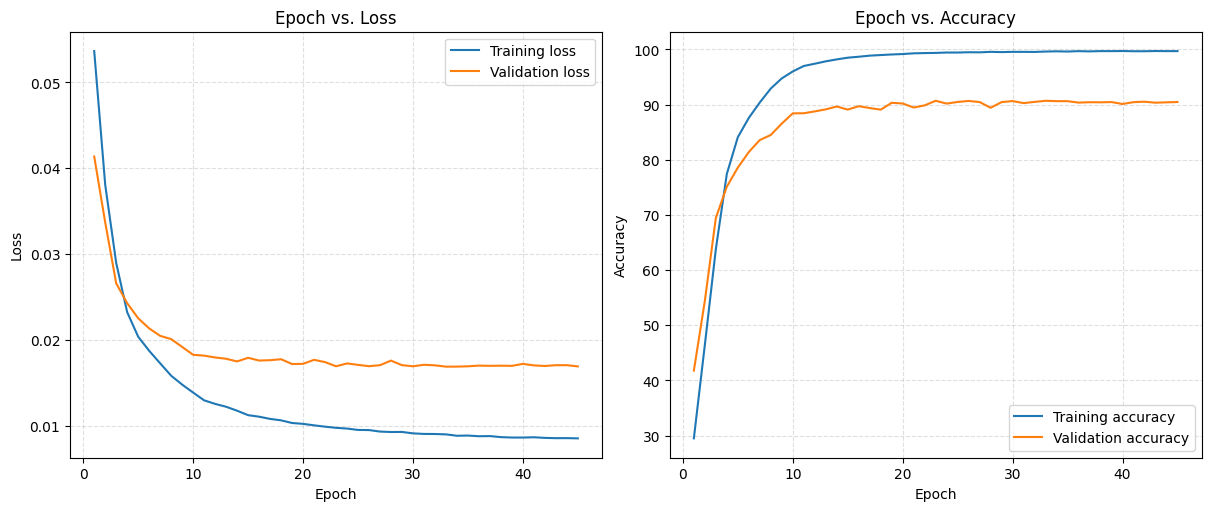

In [13]:
plot_loss_acc(history=hist)

In [14]:
loss, acc = validate_one_epoch(model, loss_fn, test_dl, device=device)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:3.3f}%")

Test loss: 0.0132, Test accuracy: 96.247%


In [15]:

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1 ,1)
    return (img * std + mean).clamp(0, 1)
    
def plot_results(img):
    # -- Separate copies -- 
    img_model = img.detach().clone()    # goes into model
    img_vis   = img.detach().clone()
    
    # --- send model input to same device as model ---
    device = next(model.parameters()).device
    img_model = img_model.unsqueeze(0).to(device) # add batch dim + move
    
    model.eval()
    with torch.inference_mode():
        kps = model(img_model).detach().cpu().squeeze(0) # Shape [136]
    
    # assuming keypoints are in [0,1]
    kps_x = kps[:68] * 224
    kps_y = kps[68:] * 224
    
    # --- unnormalize visualization image (stay on CPU) ---
    # img_vis = std * img_vis + mean
    # img_vis = img_vis.clamp(0, 1)           # keep it in [0,1] for imshow
    img_vis = denormalize(img_vis)
     
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    ax = axes[0]
    ax.imshow(img_vis.permute(1, 2, 0))
    ax.set_title("Original Image")
    
    # right: image + facial points
    ax = axes[1]
    img_model = img_model.squeeze(0).detach().cpu()
    img_model = denormalize(img_model)
    ax.imshow(img_model.permute(1, 2, 0))
    ax.set_title("Image with facial points")
    ax.scatter(kps_x, kps_y, c='r', s=15)

    plt.show()

img_bgr.shape: (1596, 1488, 3)
img_rgb.shape: (1596, 1488, 3)
img_resized.shape: (224, 224, 3)


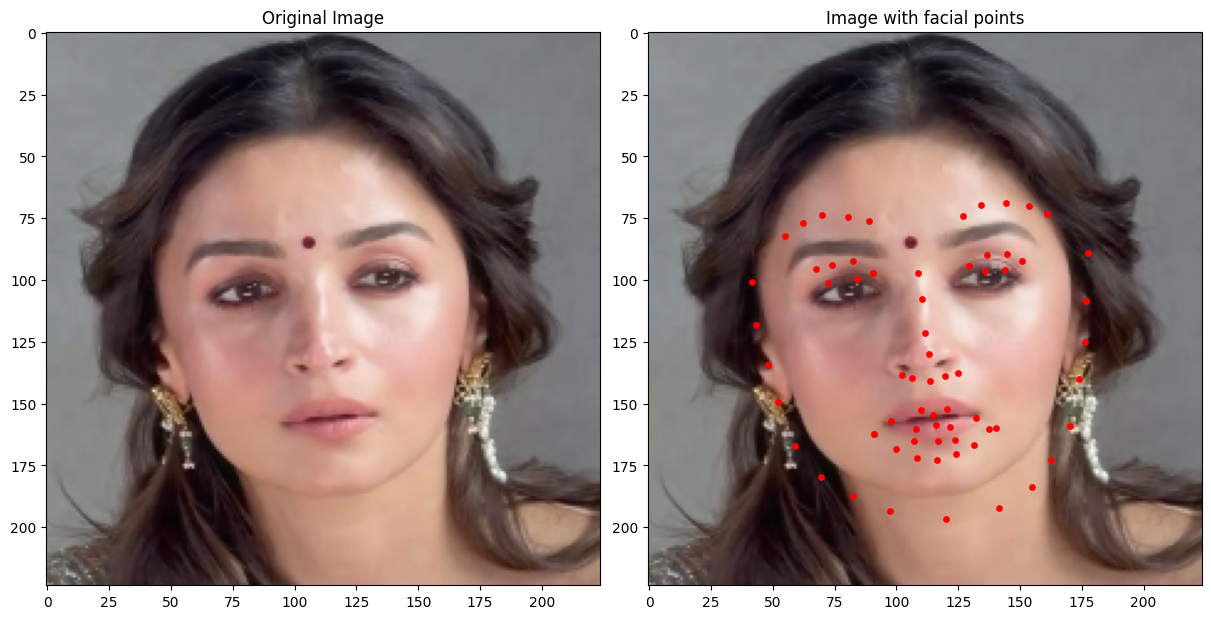

In [16]:
IMAGE_INDEX = 25

# images, _ = next(iter(test_dl))
# img = images[IMAGE_INDEX]

# plot_results(img)
    
# /225 - > resize -> change to CHW -> normalize
def preprocess_image(image_path):
    # 1. read the image
    img_bgr = cv2.imread(image_path)
    print(f"img_bgr.shape: {img_bgr.shape}")
    
    # 2. BGR->RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    print(f"img_rgb.shape: {img_rgb.shape}")
        
    # 3. resize to 224, 224, 3
    img_resized = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_LINEAR)
    print(f"img_resized.shape: {img_resized.shape}")
    # plt.figure(figsize=(5,5))
    # plt.imshow(img_resized)
    # plt.show()
    
    # 4. change to CHW, / 255
    img_t = torch.from_numpy(img_resized).permute(2, 0, 1).float()/255.0
        
    # 6. normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1 ,1)
    img_t = (img_t - mean)/std
    
    # # 7. to(device)
    # img_t = img_t.to(torch.device("cuda"))
    
    return img_t 

image_path = "/home/onkar/Good/modern-cv-with-pytorch/images/LadyFace2.png"
img_t = preprocess_image(image_path)

plot_results(img_t)